# Fashion Recommender System Using Transfer Learning Models


Importing dataset from kaggle (https://www.kaggle.com/paramaggarwal/fashion-product-images-small)

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuvashreerchan","key":"2ee764e8fb92651f001fd4f503cd01bd"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

 97% 550M/565M [00:08<00:00, 68.2MB/s]
100% 565M/565M [00:08<00:00, 68.9MB/s]


In [ ]:
!unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import pathlib

In [ ]:
from PIL import Image

In [ ]:
DATASET_PATH = "/content/myntradataset/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [ ]:
# Load the dataset
styles_df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=6000, error_bad_lines=False)

<ipython-input-17-b218eee20faa>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  styles_df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=6000, error_bad_lines=False)


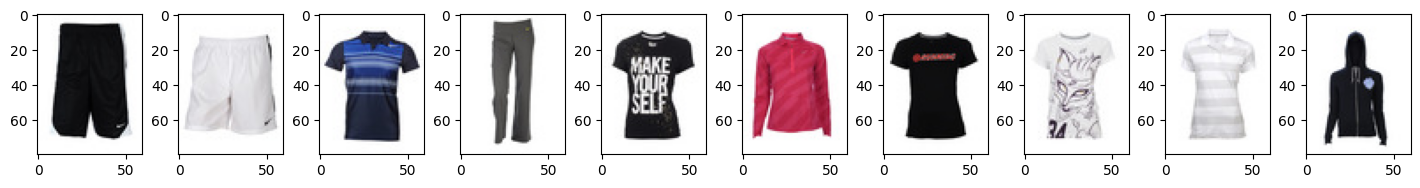

In [ ]:
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/100'+ str(i) +'.jpg')
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

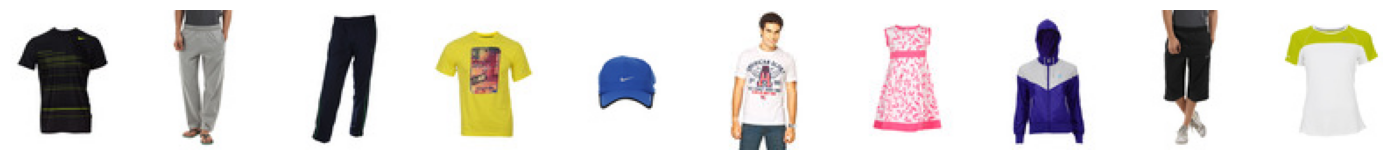

In [ ]:
plt.figure(figsize=(20, 20))

# Display images from 10010.jpg to 10020.jpg
for i in range(10, 20):
    plt.subplot(6, 10, i - 10 + 1)
    cloth_img = mpimg.imread(DATASET_PATH + 'images/100' + str(i) + '.jpg')
    plt.imshow(cloth_img)
    plt.axis('off')  # Turn off axis for better visualization

plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

Pre-processing

Merging the csv data with image data

In [ ]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

<ipython-input-13-4b524f8a7fff>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

   year   usage                             productDisplayName      image  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg  
5  2011  Casual           Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012  Ethnic               Fabindia Men Striped Green Shirt  30805.jpg  
7  2012  Casual                  Jealous 21 Women Purple Shirt  26960.jpg  
8  2012  Casual                       Puma Men Pack of 3 Socks  29114.jpg  
9  2016  Casual                         Skagen Men Black Watch  30039.jpg

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  5000 non-null   int64 
 1   gender              5000 non-null   object
 2   masterCategory      5000 non-null   object
 3   subCategory         5000 non-null   object
 4   articleType         5000 non-null   object
 5   baseColour          5000 non-null   object
 6   season              4999 non-null   object
 7   year                5000 non-null   int64 
 8   usage               4953 non-null   object
 9   productDisplayName  4999 non-null   object
 10  image               5000 non-null   object
dtypes: int64(2), object(9)
memory usage: 429.8+ KB


In [ ]:
# Resolution and Quality
def assess_image_quality(image_path):
    with Image.open(image_path) as img:
        resolution = img.size
        mode = img.mode
        quality = img.info.get("quality", None)
        return resolution, mode, quality

In [ ]:
sample_image_path = "/content/myntradataset/images/10020.jpg"
resolution, mode, quality = assess_image_quality(sample_image_path)
print(f"Resolution: {resolution}, Mode: {mode}, Quality: {quality}")

Resolution: (60, 80), Mode: RGB, Quality: None


Visualizing the distribution of products across different categories

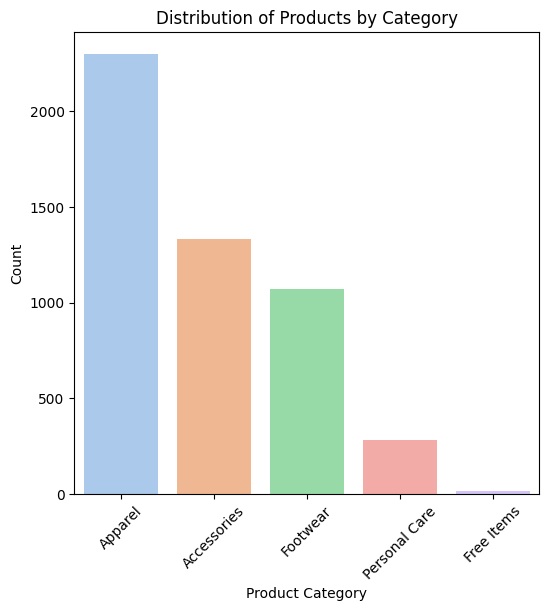

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(x='masterCategory', data=df,palette='pastel')
plt.title('Distribution of Products by Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Displaying count of every category of wearable/Clothing products

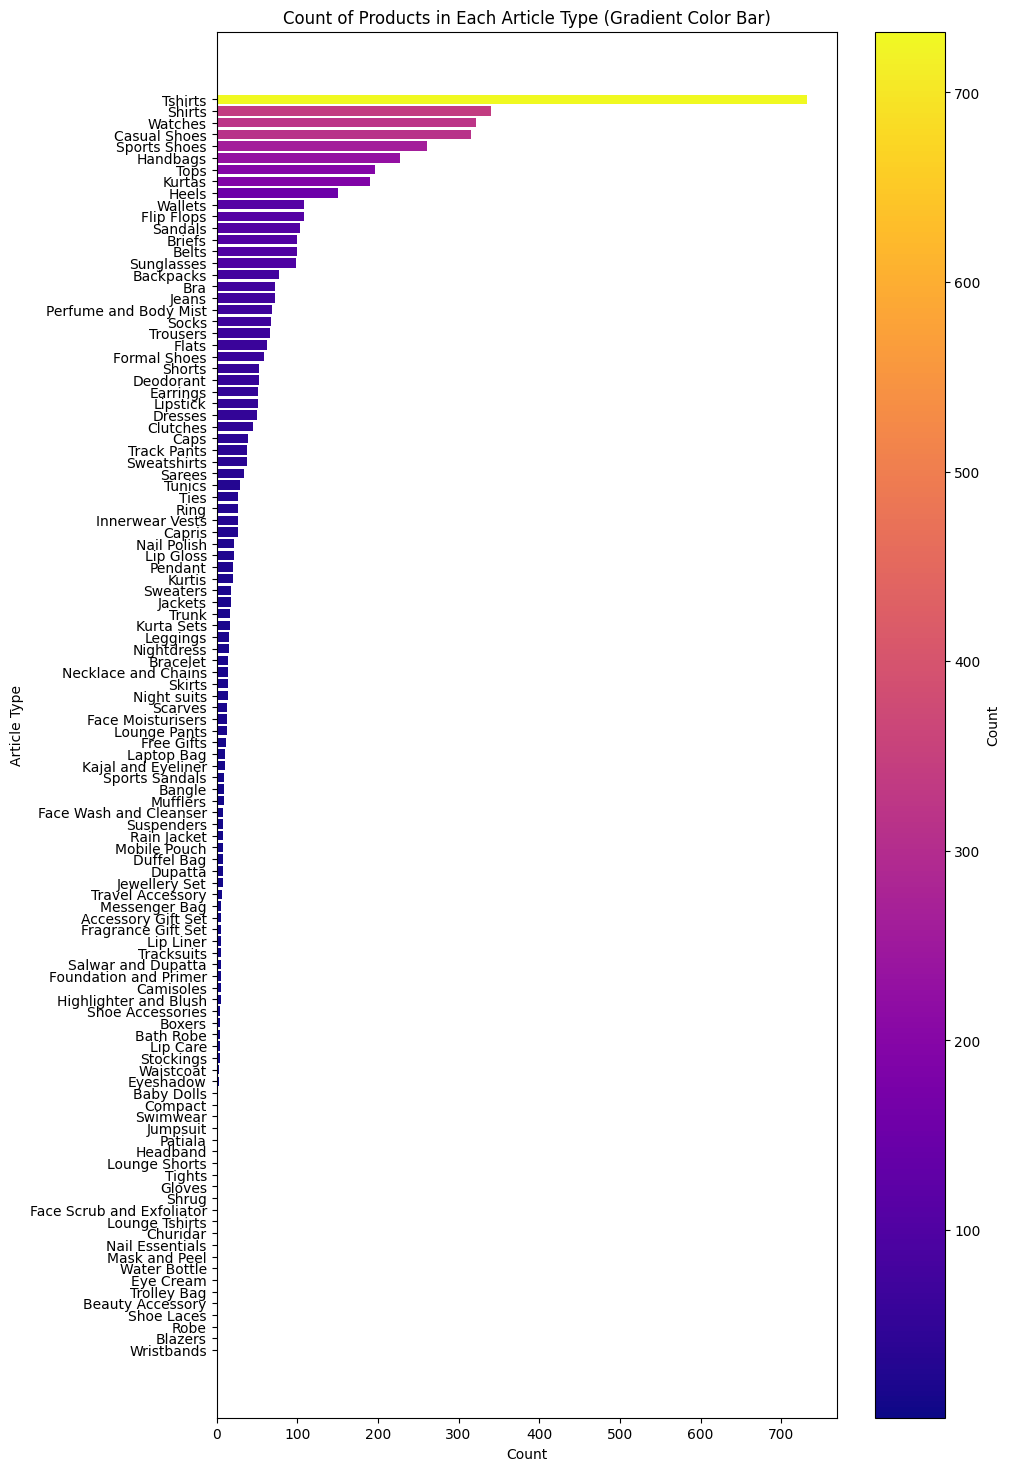

In [ ]:
from matplotlib.colors import Normalize
# Calculate the count of each article type
article_type_counts = df['articleType'].value_counts().sort_values()

# Normalizing the data to fit within the colormap range
norm = Normalize(vmin=article_type_counts.min(), vmax=article_type_counts.max())
colormap = plt.cm.plasma

# Plotting the count of products in each article type with a gradient color bar
plt.figure(figsize=(10,18))
bars = plt.barh(article_type_counts.index, article_type_counts, color=colormap(norm(article_type_counts)))
plt.xlabel('Count')
plt.ylabel('Article Type')


# Adding color bar to show the mapping of article type counts to colors
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=plt.gca(), orientation='vertical')
cbar.set_label('Count')

plt.title('Count of Products in Each Article Type (Gradient Color Bar)')
plt.show()

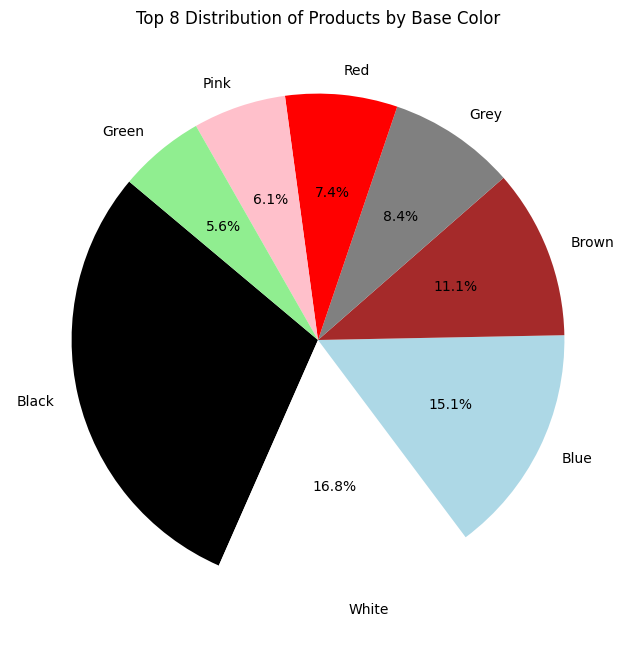

In [ ]:
top_colors = df['baseColour'].value_counts().head(8)

color_mapping = {
    'Red': 'red',
    'Blue': 'lightblue',
    'Green': 'lightgreen',
    'Black':'black',
     'Grey':'grey',
    'White':'white',
    'Brown':'brown',
    'Pink':'pink'
}

# Creating a list of colors for the pie chart slices based on the color_mapping dictionary
colors = [color_mapping.get(color, 'gray') for color in top_colors.index]

plt.figure(figsize=(8, 8))
plt.pie(top_colors, labels=top_colors.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Top 8 Distribution of Products by Base Color')
plt.show()


In [ ]:
!pip install wordcloud

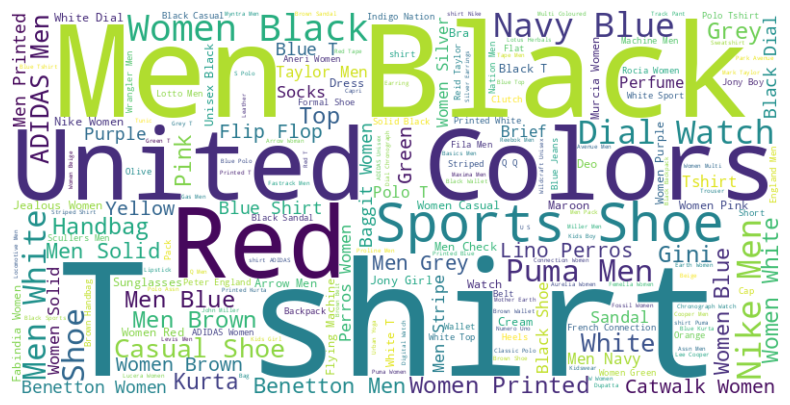

In [ ]:
from wordcloud import WordCloud

# Concatenate product titles into a single string
text = ' '.join(df['productDisplayName'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

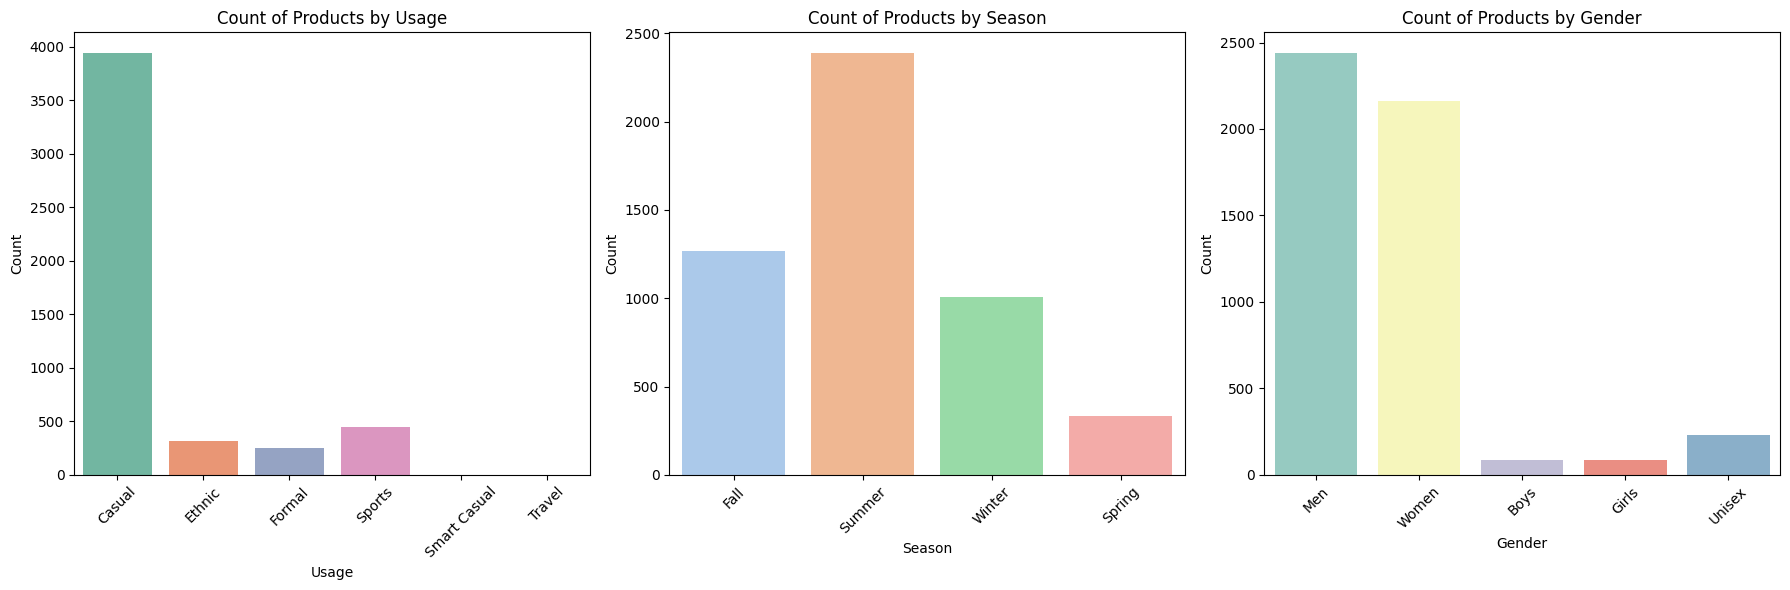

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# bar chart for 'usage'
sns.countplot(x='usage', data=df, palette='Set2', ax=axs[0])
axs[0].set_title('Count of Products by Usage')
axs[0].set_xlabel('Usage')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)

# bar chart for 'season'
sns.countplot(x='season', data=df, palette='pastel', ax=axs[1])
axs[1].set_title('Count of Products by Season')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

# bar chart for 'gender'
sns.countplot(x='gender', data=df, palette='Set3', ax=axs[2])
axs[2].set_title('Count of Products by Gender')
axs[2].set_xlabel('Gender')
axs[2].set_ylabel('Count')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


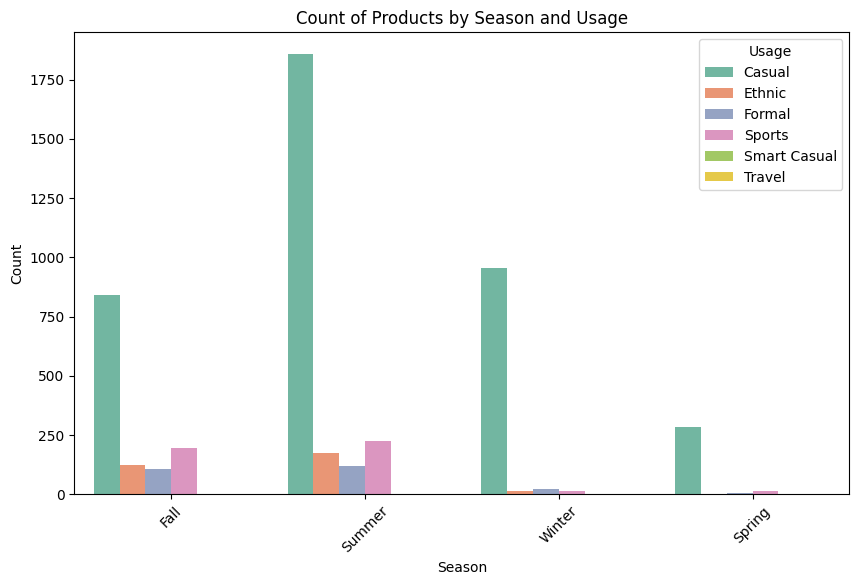

In [ ]:
import seaborn as sns

# count plot for 'season' and 'usage'
plt.figure(figsize=(10, 6))
sns.countplot(x='season', hue='usage', data=df, palette='Set2')
plt.title('Count of Products by Season and Usage')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Usage')
plt.show()

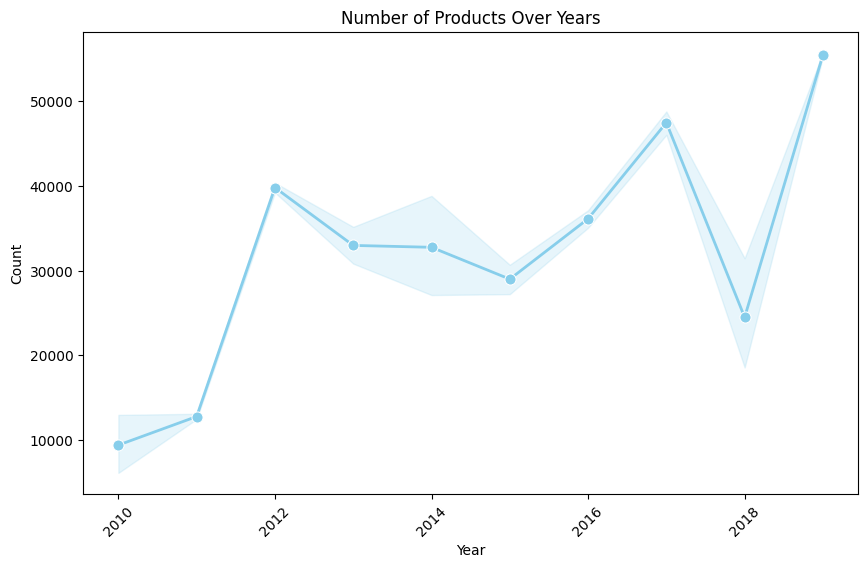

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='id',data=df, marker='o', color='skyblue', linewidth=2, markersize=8)
plt.title('Number of Products Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Checking for null values in the entire DataFrame
null_values = df.isnull().sum()

print("Columns with Null Values:")
print(null_values[null_values > 0])

Columns with Null Values:
season                 1
usage                 47
productDisplayName     1
dtype: int64


Model Building

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
img_width, img_height, chnl = 200, 200, 3

In [ ]:
#DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = False

model_dense = keras.Sequential([densenet,GlobalMaxPooling2D()])
model_dense.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 7037504 (26.85 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:
#Resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, chnl))
resnet.trainable = False
model_resnet = keras.Sequential([resnet,GlobalMaxPooling2D()])

model_resnet.summary()


94765736/94765736 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(img_width, img_height, chnl))
vgg.trainable=False
model_vgg = keras.Sequential([vgg,GlobalMaxPooling2D()])
model_vgg.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
def img_path(img):
    return DATASET_PATH + 'images/' + img
def model_predict(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

DenseNet embeddings

In [ ]:
df_copy1      = df
df_embedding1 = df_copy1['image'].apply(lambda x: model_predict(model_dense, x))
df_embedding1 = df_embedding1.apply(pd.Series)
df_embedding1.head(5)

1/1 [==============================] - 0s 147ms/step


ResNet50 embeddings

In [ ]:
df_copy2     = df
df_embedding2 = df_copy2['image'].apply(lambda x: model_predict(model_resnet, x))
df_embedding2 = df_embedding2.apply(pd.Series)
df_embedding2.head(5)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 189ms/step


0         1         2         3         4     5         6        7     \
0  0.000000  0.654194  0.174129  1.026756  3.661913   0.0  4.570984  0.00000   
1  0.089982  0.985371  0.000000  2.582211  5.242714   0.0  3.190962  0.00000   
2  0.000000  1.686443  0.093070  1.408280  2.793005   0.0  3.678887  0.00000   
3  0.000000  0.493873  0.000000  4.835564  7.473885   0.0  3.079197  0.83265   
4  0.000000  2.259118  0.000000  2.643834  2.568426   0.0  3.929397  0.00000   

       8         9     ...      2038      2039      2040      2041      2042  \
0  3.728843  0.161972  ...  1.553329  0.000000  3.187359  0.000000  1.147055   
1  1.402248  0.000000  ...  2.403227  0.000000  1.766761  0.000000  0.000000   
2  2.619771  0.000000  ...  2.088861  0.000000  0.000000  0.000000  0.000000   
3  2.922189  0.000000  ...  1.937640  2.411918  1.450236  0.000000  0.000000   
4  2.264754  0.000000  ...  3.268188  0.217552  2.145502  1.633718  0.040633   

       2043      2044      2045      2046      2047  
0  3.631071  0.000000  9.117006  3.495529  0.959238  
1  2.785151  0.000000  6.062467  5.397776  0.449319  
2  0.000000  0.000000  9.980749  2.049761  0.000000  
3  2.124941  0.753138  7.835529  6.929099  1.029551  
4  1.223833  0.000000  9.307408  8.296408  0.000000  

[5 rows x 2048 columns]

VGG embeddings

In [ ]:
df_copy3     = df
df_embedding3 = df_copy3['image'].apply(lambda x: model_predict(model_vgg, x))
df_embedding3 = df_embedding3.apply(pd.Series)
df_embedding3.head(5)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 436ms/step


0         1         2         3         4         5         6    \
0  1.644407  0.000000  0.902178  0.910090  0.420428  0.000000  2.298997   
1  0.934483  0.965171  0.895149  0.000000  0.826164  0.000000  0.550216   
2  2.385170  0.000000  1.618434  2.651848  0.368372  0.854072  2.842782   
3  0.036597  0.000000  0.275556  0.000000  1.499351  0.000000  1.280986   
4  1.008840  0.000000  1.670843  1.299987  0.858919  0.587320  2.472529   

        7         8         9    ...       502       503       504       505  \
0  2.791480  1.775548  0.000000  ...  1.882644  2.483800  0.152111  0.303340   
1  1.958884  0.657641  0.000000  ...  1.251366  4.443592  0.367615  1.104147   
2  0.055518  0.000000  1.645044  ...  1.648801  0.626700  0.642798  0.000000   
3  0.072011  0.000000  0.000000  ...  1.322177  4.268617  0.376122  0.606314   
4  1.357729  0.754673  0.000000  ...  1.609792  3.229031  0.413135  1.516541   

        506       507       508       509       510       511  
0  0.953922  0.949353  1.771004  0.094403  1.020538  0.000000  
1  0.348347  1.172423  1.727709  0.794590  2.051220  0.495933  
2  0.000000  1.018217  0.496335  0.000000  0.984316  0.000000  
3  0.472987  0.638498  1.457755  0.000000  0.703641  0.045586  
4  0.941915  0.634968  3.043236  0.450548  0.890279  0.080901  

[5 rows x 512 columns]

In [ ]:
print(df_embedding1.shape) #DesneNet121

(5000, 1024)


In [ ]:
print(df_embedding2.shape) #Resnet50

(5000, 2048)


In [ ]:
print(df_embedding3.shape) #VGG16

(5000, 512)


Test Image

In [ ]:
url="/content/shoe.png"

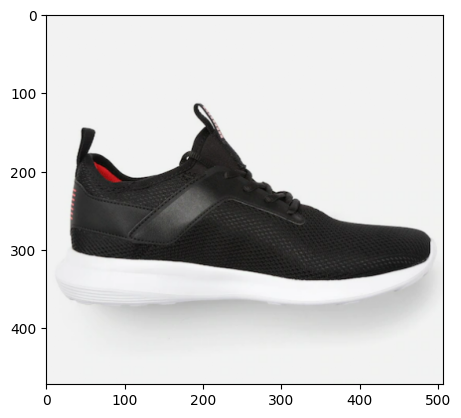

In [ ]:
a = plt.imread(url)
plt.imshow(a)

In [ ]:
def model_predict(model, url):
     # Reshape
     img = image.load_img(url, target_size=(img_width, img_height))
     # img to Array
     x   = image.img_to_array(img)
     # Expand Dim (1, w, h)
     x   = np.expand_dims(x, axis=0)
     # Pre process Input
     x   = preprocess_input(x)
     return model.predict(x)

In [ ]:
df_dn = model_predict(model_dense, url)

1/1 [==============================] - 0s 274ms/step


In [ ]:
print(df_dn)
print(df_dn.shape)

[[1.0167127e-03 8.4392894e-03 7.3767942e-03 ... 7.4299126e+00
  1.6196659e-01 5.0769253e+00]]
(1, 1024)


In [ ]:
df_rn = model_predict(model_resnet, url)

1/1 [==============================] - 0s 293ms/step


In [ ]:
print(df_rn)
print(df_rn.shape)

[[0.        1.0547503 0.        ... 7.42684   1.607844  0.       ]]
(1, 2048)


In [ ]:
df_vgg=model_predict(model_vgg, url)

1/1 [==============================] - 0s 464ms/step


In [ ]:
print(df_vgg)
print(df_vgg.shape)

[[1.02031350e+00 0.00000000e+00 9.72375214e-01 1.30422282e+00
  2.16376567e+00 0.00000000e+00 5.83890557e-01 0.00000000e+00
  1.97079986e-01 5.73905897e+00 0.00000000e+00 5.92827737e-01
  1.41350484e+00 0.00000000e+00 1.37628615e-01 1.26568198e+00
  1.30703461e+00 1.60581028e+00 0.00000000e+00 2.85551727e-01
  4.88120258e-01 4.81345505e-01 1.27349937e+00 1.28006542e+00
  4.15965855e-01 0.00000000e+00 3.44479799e+00 4.26155567e+00
  0.00000000e+00 0.00000000e+00 2.53005815e+00 9.61089730e-01
  1.07164490e+00 6.48107231e-01 6.69037700e-01 0.00000000e+00
  7.26869822e-01 1.06604867e-01 0.00000000e+00 0.00000000e+00
  1.07713544e+00 7.76631951e-01 1.28680444e+00 0.00000000e+00
  3.34126616e+00 3.35197067e+00 1.21034300e+00 1.13314402e+00
  4.96163696e-01 1.82252347e+00 1.17687786e+00 6.13626659e-01
  2.57275295e+00 2.09117746e+00 1.86643219e+00 7.39494443e-01
  6.22914135e-01 5.90389431e-01 5.74989974e-01 7.00412631e-01
  0.00000000e+00 0.00000000e+00 3.45100373e-01 7.71940172e-01
  0.0000

In [ ]:
df_dn = pd.DataFrame(df_dn)
print(df_dn)
df_rn = pd.DataFrame(df_rn)
print(df_rn)
df_vgg = pd.DataFrame(df_vgg)
print(df_vgg)

       0         1         2         3         4         5        6     \
0  0.001017  0.008439  0.007377  0.007538  0.532814  1.149862  0.00123   

       7         8         9     ...      1014      1015      1016      1017  \
0  0.018826  0.583764  0.000939  ...  1.088745  1.393451  5.160206  1.929244   

       1018      1019      1020      1021      1022      1023  
0  5.205926  0.899869  0.423642  7.429913  0.161967  5.076925  

[1 rows x 1024 columns]
   0        1     2     3         4     5         6         7        8     \
0   0.0  1.05475   0.0   0.0  1.671525   0.0  3.223349  0.165916  3.16398   

       9     ...  2038  2039      2040  2041      2042      2043  2044  \
0  0.260309  ...   0.0   0.0  1.738044   0.0  0.978741  1.722535   0.0   

      2045      2046  2047  
0  7.42684  1.607844   0.0  

[1 rows x 2048 columns]
        0    1         2         3         4    5         6    7        8    \
0  1.020314  0.0  0.972375  1.304223  2.163766  0.0  0.583891  0.0  0.1

In [ ]:
cosine_sim1 = linear_kernel(df_dn, df_embedding1)
print(cosine_sim1[0])

[4166.929  5521.453  5510.5396 ... 6081.488  5494.2305 5088.9297]


In [ ]:
cosine_sim2 = linear_kernel(df_rn, df_embedding2)
print(cosine_sim2[0])

[13319.584 13309.081 12766.087 ... 14806.747 16015.95  13494.994]


In [ ]:
cosine_sim3 = linear_kernel(df_vgg, df_embedding3)
print(cosine_sim3[0])

[659.38495 627.36835 566.9427  ... 607.83386 671.37103 554.2625 ]


In [ ]:
def range_cs(cosine_sim):
  x_min=cosine_sim.min(axis=1)
  x_max=cosine_sim.max(axis=1)
  norm=(cosine_sim-x_min)/(x_max-x_min)[:, np.newaxis]
  return norm

In [ ]:
dn_norm=range_cs(cosine_sim1)
rn_norm=range_cs(cosine_sim2)
vgg_norm=range_cs(cosine_sim3)

In [ ]:
def get_recommendations(x, df, cosine_sim):

    # the pairwsie similarity scores of all clothes with that one
    sim_scores = list(enumerate(cosine_sim[x]))

    # Sorting the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Returning the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(3285, 1.0), (1018, 0.96073043), (10, 0.9548702), (230, 0.95402867), (2170, 0.9529735)]


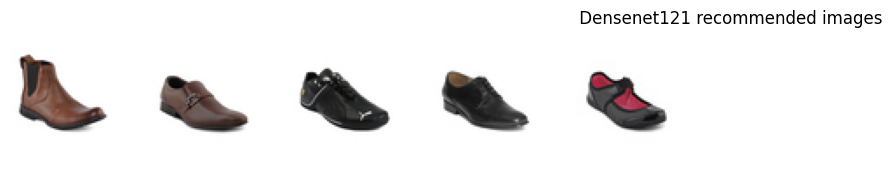

In [ ]:
chosen_img_indx = 0
recommendation = get_recommendations(chosen_img_indx, df, dn_norm)
recommendation_list = recommendation.to_list()

plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title(" Densenet121 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

[(4437, 1.0), (1886, 0.98952806), (1988, 0.9513504), (2306, 0.94870883), (4079, 0.9356843)]


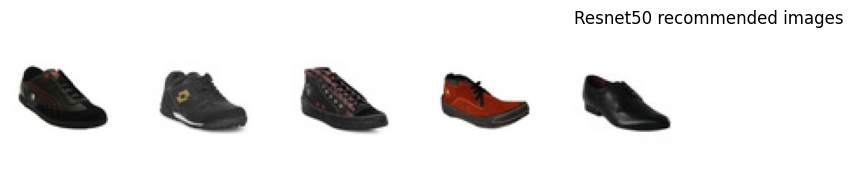

In [ ]:
chosen_img_indx = 0
recommendation = get_recommendations(chosen_img_indx, df, rn_norm)
recommendation_list = recommendation.to_list()

plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Resnet50 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

[(4598, 1.0), (1142, 0.96959126), (4084, 0.9549752), (4724, 0.9479289), (480, 0.94058216)]


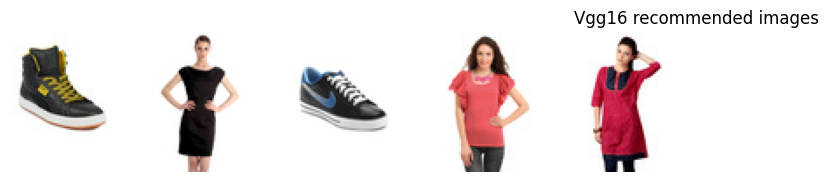

In [ ]:
chosen_img_indx = 0

recommendation = get_recommendations(chosen_img_indx, df, vgg_norm)
recommendation_list = recommendation.to_list()

plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Vgg16 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)

In [ ]:
tsne_results1 = tsne.fit_transform(df_embedding1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 36.47108507156372 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results1[:,0]
df['tsne-2d-two'] = tsne_results1[:,1]

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

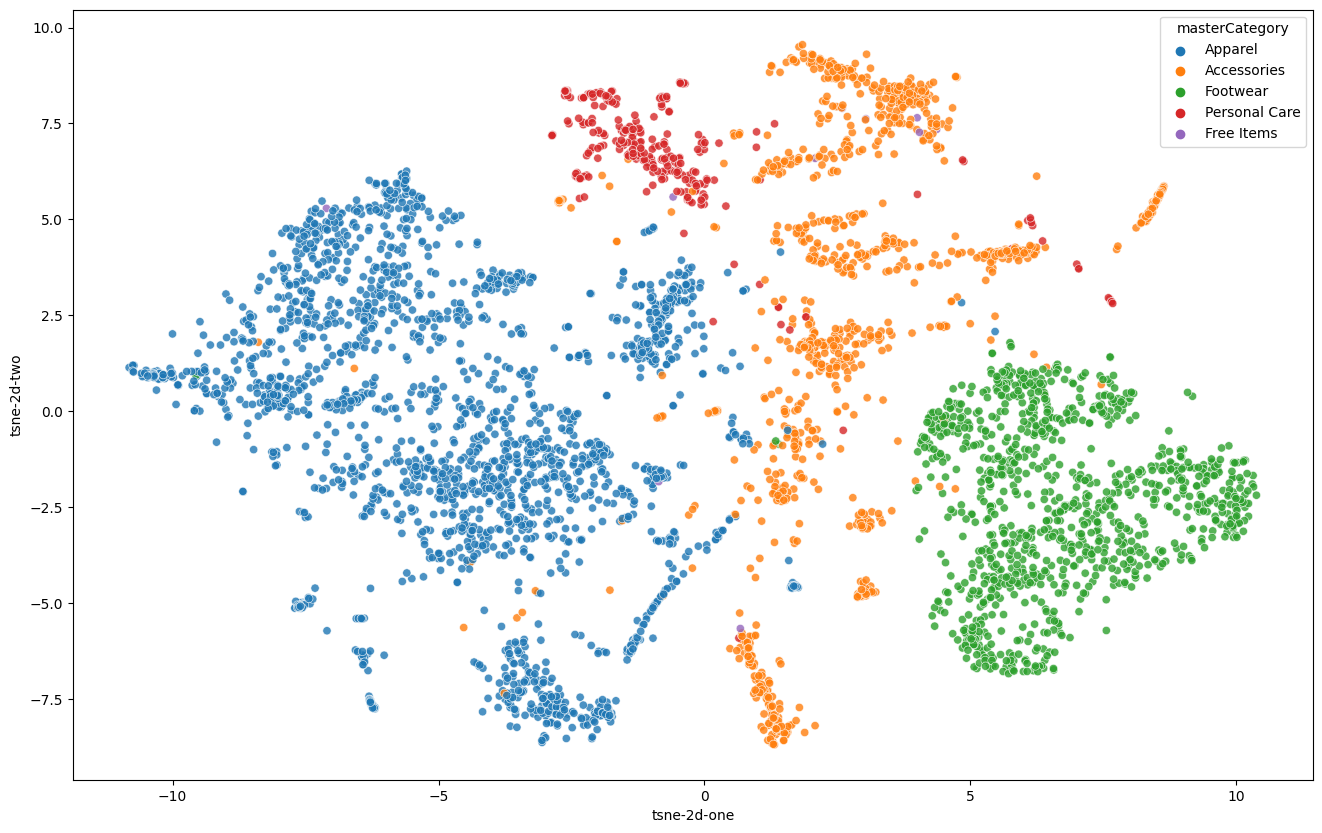

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

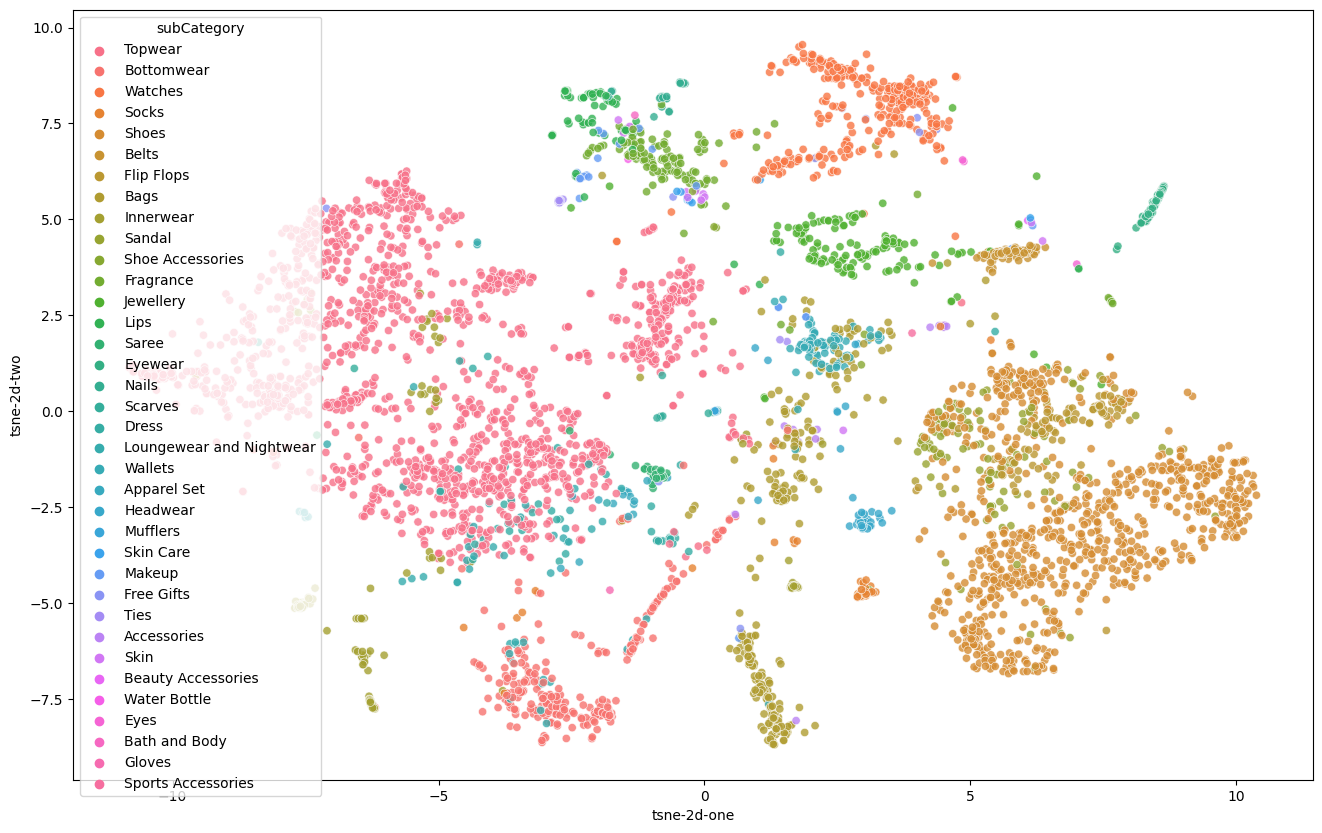

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
tsne_results2 = tsne.fit_transform(df_embedding2)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 70.04013776779175 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results2[:,0]
df['tsne-2d-two'] = tsne_results2[:,1]

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

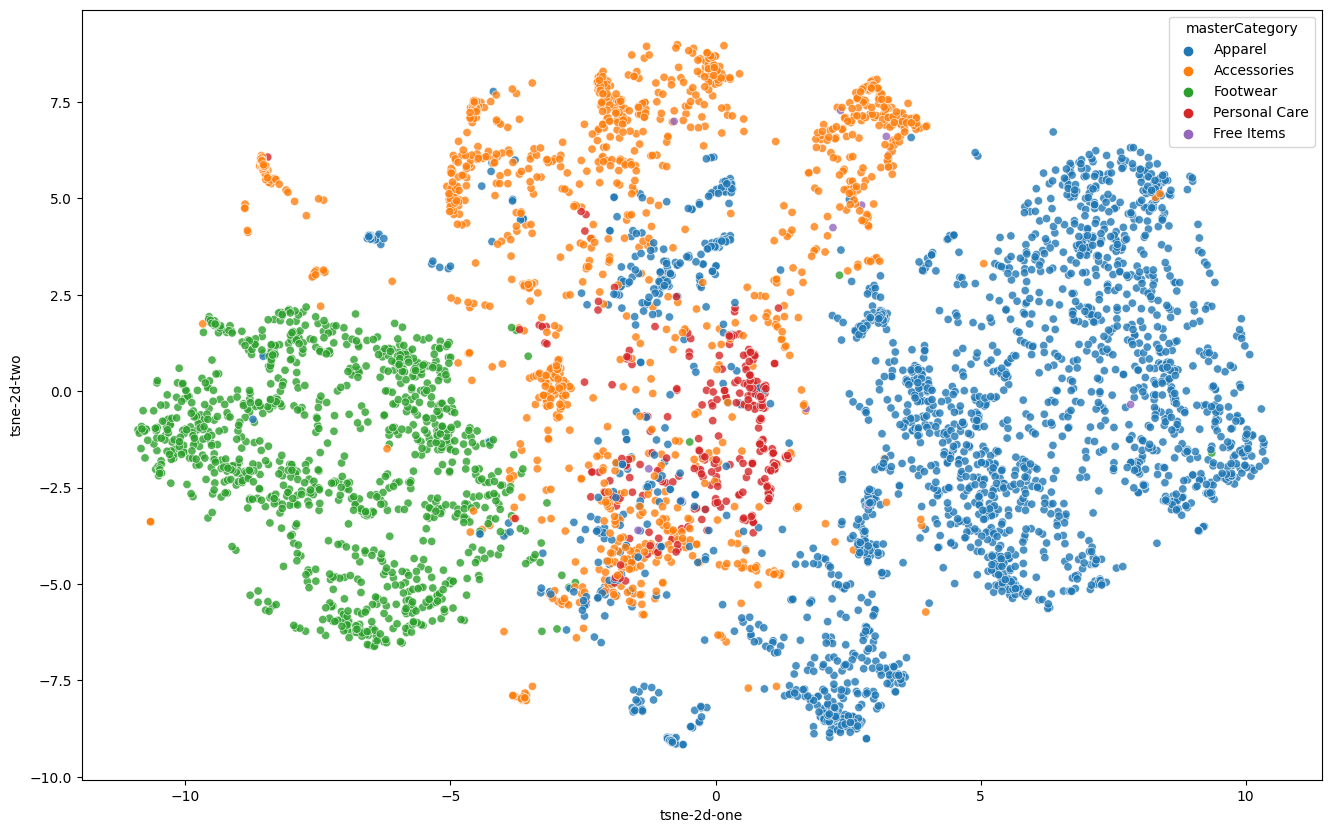

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

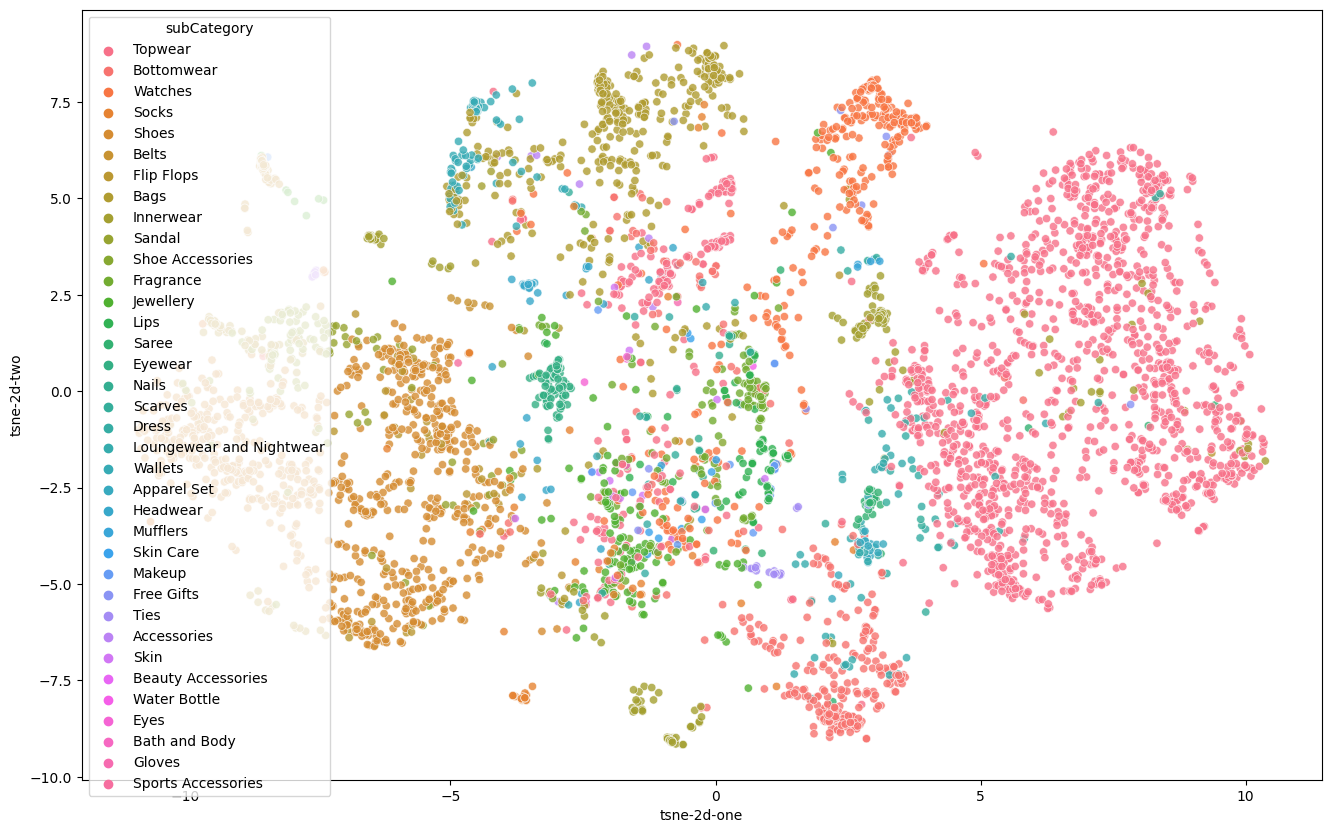

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
tsne_results3 = tsne.fit_transform(df_embedding3)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 181.94663262367249 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results3[:,0]
df['tsne-2d-two'] = tsne_results3[:,1]

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

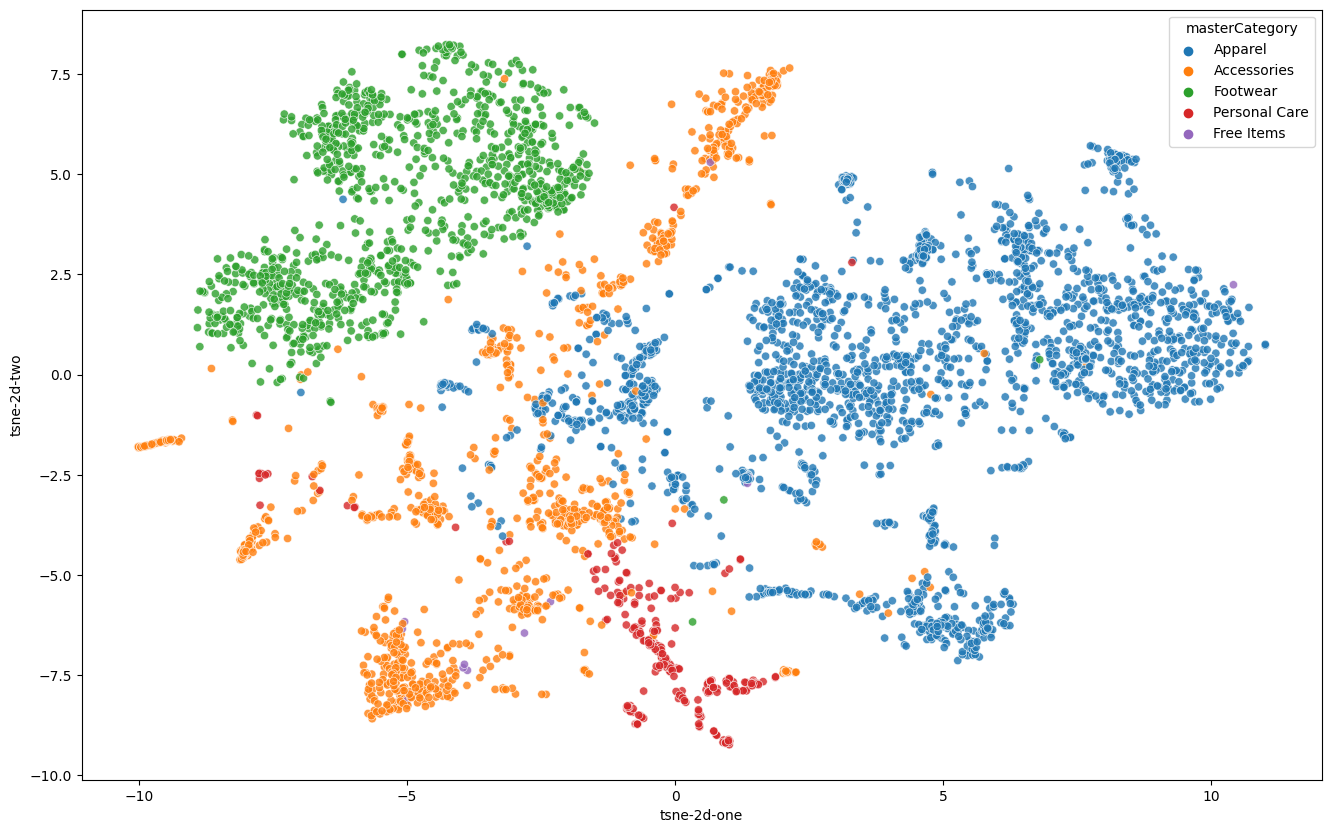

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

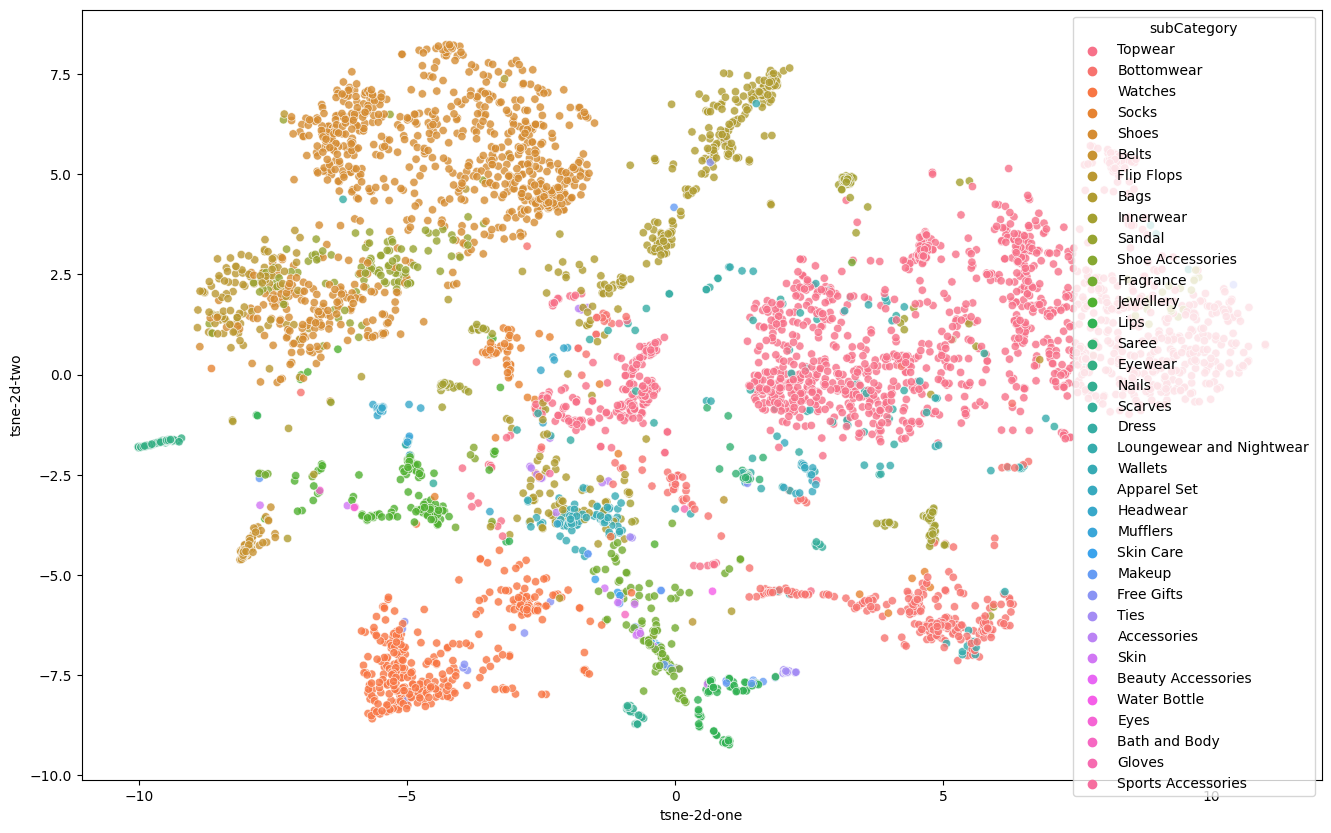

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)